# Classifying human emotions with ResNet34

This notebook focuses on classifying human facial emotions using a fine-tuned ResNet50 convolutional neural network. The goal is to achieve robust emotion recognition by experimenting with various hyperparameter ranges and leveraging AWS infrastructure for training, deployment, and inference.

In [1]:
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3


In [100]:
!pip install protobuf==3.20.*

In [10]:
!pip install kaggle

  Using cached kaggle-1.7.4.2-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.2-py3-none-any.whl (173 kB)


In [35]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 36.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 158.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 167.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 21.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 60.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 146.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 52.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 44.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15

In [11]:
import sagemaker
import boto3
import kaggle
import matplotlib.pyplot as plt
from torchvision import transforms

Importing Kaggle API key to access dataset:

In [1]:
!mkdir -p ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Dataset
For this project we will be using the FER2013 (Facial Expression Recognition) dataset from Kaggle. 
This dataset contains ~32,000 greyscale images of faces (48x48). There are 7 classes of images in this dataset:
- 0 = Angry
- 1 = Disgust
- 2 = Fear
- 3 = Happy
- 4 = Neutral
- 5 = Sad
- 6 = Surprise

In [22]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/home/ec2-user/.kaggle'

os.makedirs('/home/ec2-user/.kaggle', exist_ok=True)

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

api.dataset_download_files('msambare/fer2013', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


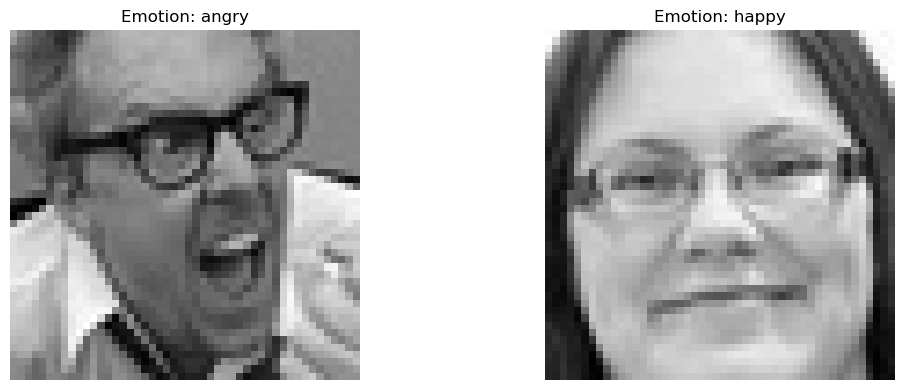

In [65]:
from PIL import Image

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(Image.open('train/angry/Training_3908.jpg').convert('L'), cmap='gray')
axes[0].set_title("Emotion: angry")
axes[0].axis('off')

axes[1].imshow(Image.open('train/happy/Training_1206.jpg').convert('L'), cmap='gray')
axes[1].set_title("Emotion: happy")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [45]:
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()

Uploading train and test datasets to s3:

In [32]:
# upload data to s3 bucket
prefix = 'image-classification/data/test'

inputs = session.upload_data('test', bucket=bucket, key_prefix=prefix)
print("Test data uploaded to: {}".format(inputs))

Test data uploaded to: s3://sagemaker-us-east-1-273441689893/image-classification/data/test


In [31]:
prefix = 'image-classification/data/train'

inputs = session.upload_data('train', bucket=bucket, key_prefix=prefix)
print("Train data uploaded to: {}".format(inputs))

Train data uploaded to: s3://sagemaker-us-east-1-273441689893/image-classification/data/train


Testing the resizing of the images to fit the expected input of the model:

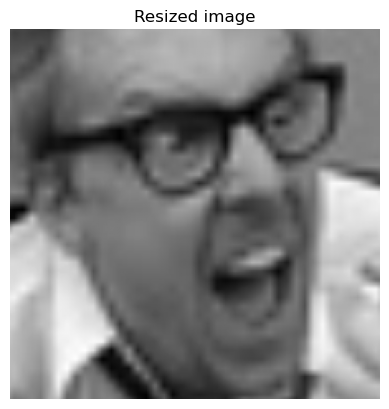

In [41]:
# testing resizing of image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

img = Image.open('train/angry/Training_3908.jpg')
img = preprocess(img)

plt.imshow(img, cmap='grey')
plt.title("Resized image")
plt.axis('off')
plt.show()

## Hyperparameter Tuning

Now we specify what Hyperparameters we want to tune and in what ranges this should happen.

In [57]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

In [61]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256]),
    "epochs": IntegerParameter(2, 10)
}

objective_metric_name = 'test loss'
objective_type = 'Minimize'
metric_definitions = [{"Name": "test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [62]:
estimator = PyTorch(
    entry_point='hpo.py',
    framework_version='1.8',
    py_version='py36',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge'
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type=objective_type,
    max_jobs=4,
    max_parallel_jobs=2
)

In [63]:
data_channels = {
    "train": f"s3://{bucket}/image-classification/data/train/",
    "test": f"s3://{bucket}/image-classification/data/test/"
}

Fine-tuning the model:

In [64]:
tuner.fit(data_channels)

[04/16/25 20:57:47] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=977012;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=963011;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[04/16/25 20:57:48] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=790036;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=202221;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=583664;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=180899;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=754020;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=683168;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=134543;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=397666;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=219346;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=406907;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250416-2057                                                          

....................................................................................................................................................................................................!


Retrieving the best hyperparameters from our hyperparameter-tuning job:

In [66]:
best_estimator = tuner.best_estimator()

best_hyperparameters = best_estimator.hyperparameters()
best_hyperparameters


2025-04-16 21:13:42 Starting - Found matching resource for reuse
2025-04-16 21:13:42 Downloading - Downloading the training image
2025-04-16 21:13:42 Training - Training image download completed. Training in progress.
2025-04-16 21:13:42 Uploading - Uploading generated training model
2025-04-16 21:13:42 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"test loss"',
 'batch-size': '"256"',
 'epochs': '10',
 'lr': '0.012121246038410968',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-04-16-20-57-47-557"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-273441689893/pytorch-training-2025-04-16-20-57-47-557/source/sourcedir.tar.gz"'}

In [67]:
best_hyperparameters = {
    "lr": best_hyperparameters['lr'],
    "batch-size": best_hyperparameters['batch-size'].replace('"', ""),
    "epochs": best_hyperparameters['epochs']
}

## Model Profiling and Debugging

Now we will train the best performing model with the Debugger and Profiler.

In [68]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

[04/16/25 21:15:33] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=867207;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=42657;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [69]:

estimator = PyTorch(
    entry_point='train_model.py',
    framework_version='1.8',
    py_version='py36',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    hyperparameters=best_hyperparameters,
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config
)

estimator.fit(data_channels)

[04/16/25 21:15:35] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=188133;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=343342;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=597496;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=922524;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[04/16/25 21:15:36] INFO     Ignoring unnecessary instance type: None.                            ]8;id=471067;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=983550;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=27596;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=698582;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=73328;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=389796;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=653426;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=835778;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=562253;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=849450;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=965802;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=587071;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=251077;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=550585;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=97354;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=593869;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=758590;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=486643;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-04-16-21-15-35-731                                              

2025-04-16 21:15:41 Starting - Starting the training job...
2025-04-16 21:16:10 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2025-04-16 21:16:30 Downloading - Downloading input data...
2025-04-16 21:17:11 Downloading - Downloading the training image.....................
2025-04-16 21:20:39 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-04-16 21:20:53,886 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-04-16 21:20:53,917 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-04-16 21:20:53,960 sagemaker_pytorch_container.training INFO     Invoking user training sc

Create debugger plot:

In [70]:
from smdebug.trials import create_trial

debugger_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(debugger_path)

[2025-04-16 21:48:14.079 ip-172-16-49-65.ec2.internal:22127 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-273441689893/pytorch-training-2025-04-16-21-15-35-731/debug-output


In [71]:
print("Available tensors:", trial.tensor_names())

[2025-04-16 21:48:19.366 ip-172-16-49-65.ec2.internal:22127 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-04-16 21:48:20.386 ip-172-16-49-65.ec2.internal:22127 INFO trial.py:210] Loaded all steps
Available tensors: ['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.

In [72]:
client = session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'pytorch-training-2025-04-16-21-15-35-731',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:273441689893:training-job/pytorch-training-2025-04-16-21-15-35-731',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-273441689893/pytorch-training-2025-04-16-21-15-35-731/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '"256"',
  'epochs': '"10"',
  'lr': '"0.012121246038410968"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2025-04-16-21-15-35-731"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-273441689893/pytorch-training-2025-04-16-21-15-35-731/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-gpu-py36',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetric

In [37]:
# --! Following code from example at 
# "https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb" !--

In [73]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

3

In [74]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.core.modes import ModeKeys

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name, color='orange', marker='o', linestyle='')
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


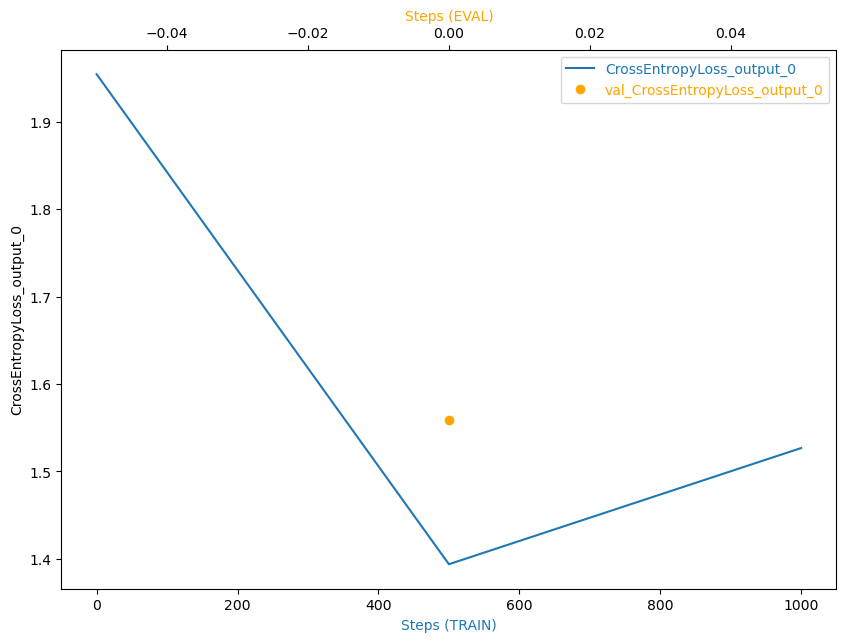

In [76]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

If there were some anomalous behaviour in the debugging output I would have digged deeper into the training job description
or analyzed the CloudWatch logs for the job.

In [77]:
import boto3

s3 = boto3.client('s3')
s3.download_file(bucket, f'{estimator.latest_training_job.name}/rule-output/ProfilerReport/profiler-output/profiler-report.html', 'profiler-report.html')

In [78]:
from IPython.display import IFrame

IFrame(src='profiler-report.html', width='100%', height='3000px')

## Model Deploying

Deploying the model to an AWS endpoint.

In [125]:
py_model = sagemaker.pytorch.PyTorchModel(
    entry_point='inference.py',
    model_data='s3://sagemaker-us-east-1-273441689893/pytorch-training-2025-04-16-21-49-55-965/model.tar.gz',
    framework_version='1.8',
    py_version='py36',
    role=role,
)

In [126]:
predictor = py_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

[04/16/25 23:54:52] INFO     Repacking model artifact                                                  ]8;id=294233;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=218238;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/model.py#820\820]8;;\
                             (s3://sagemaker-us-east-1-273441689893/pytorch-training-2025-04-16-21-49-             
                             55-965/model.tar.gz), script artifact (None), and dependencies ([]) into              
                             single tar.gz file located at                                                         
                             s3://sagemaker-us-east-1-273441689893/pytorch-inference-2025-04-16-23-54-             
                             51-877/model.tar.gz. This may take some time depending on model size...               

[04/16/25 23:55:01] INFO     Creating model with name: pytorch-inference-2025-04-16-23-55-01-508    ]8;id=837286;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=380392;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/16/25 23:55:02] INFO     Creating endpoint-config with name                                     ]8;id=543923;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=863776;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             pytorch-inference-2025-04-16-23-55-02-253                                             

                    INFO     Creating endpoint with name pytorch-inference-2025-04-16-23-55-02-253  ]8;id=380969;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=190593;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

------!

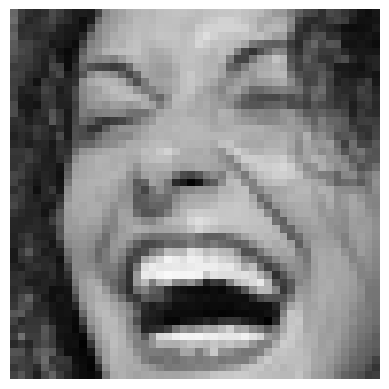

torch.Size([1, 3, 224, 224])


In [136]:
import io

preprocess_test_img = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

s3.download_file('sagemaker-us-east-1-273441689893', 'image-classification/data/test/happy/PrivateTest_14332357.jpg', 'test_img.jpg')

img = Image.open('test_img.jpg').convert('RGB')
plt.imshow(img, cmap='grey')
plt.axis('off')
plt.show()


image_tensor = preprocess_test_img(img).unsqueeze(0)
print(image_tensor.shape)

In [128]:
response = predictor.predict(image_tensor)

In [134]:
import numpy as np
prediction = np.argmax(response)
id_to_emotion = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
}

print(f"Prediction: {id_to_emotion[prediction]}")

Prediction: happy


In [135]:
predictor.delete_endpoint()

[04/17/25 00:08:36] INFO     Deleting endpoint configuration with name:                             ]8;id=222089;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=382425;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             pytorch-inference-2025-04-16-23-55-02-253                                             

                    INFO     Deleting endpoint with name: pytorch-inference-2025-04-16-23-55-02-253 ]8;id=947622;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=116744;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\